In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchinfo import summary
import torch.optim as optim
import open3d as o3d
import json
from pathlib import Path

assert torch.cuda.is_available()

# Not always necessary depending on your hardware/GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [11]:
WIDTH = 100 #meters
VOXEL_SIZE = 0.1
WIDTH_PIXELS = int(WIDTH / VOXEL_SIZE)
MIN_LIDAR_POINTS = 100

# Model scale is 16. We have input images of dimensions 1000x1000, and after the CNN we end up with 63x63 heatmaps
MODEL_SCALE = 16

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 4

# One example of the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


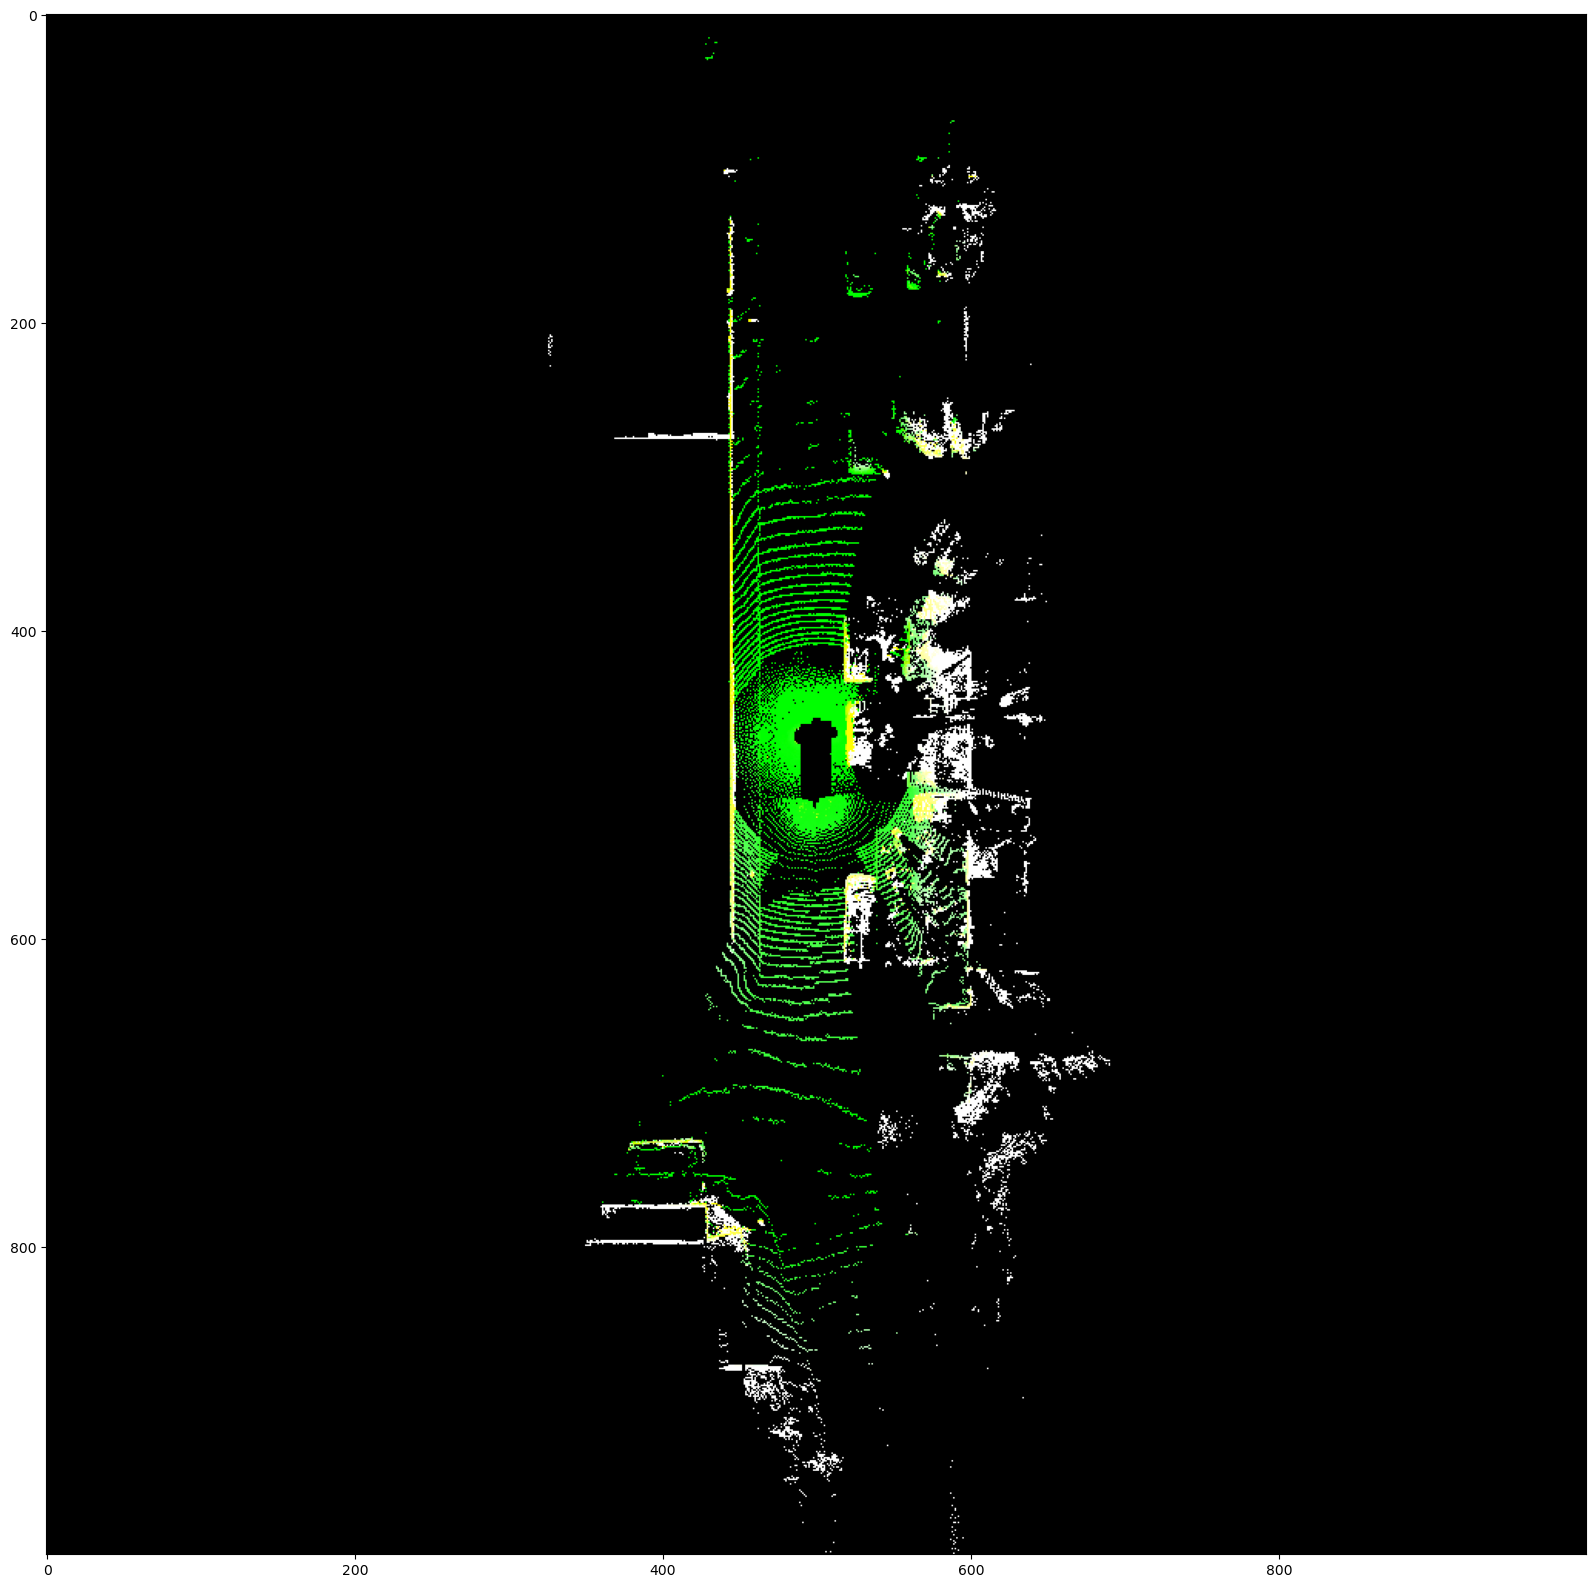

In [12]:
def ply_to_map(ply, voxel_size=0.1, angle=0.0):
    pcd = o3d.io.read_point_cloud(ply)
    point_cloud_in_numpy = np.asarray(pcd.points)
    point_cloud_in_numpy[:, 0:2] = -point_cloud_in_numpy[:, 0:2]

    rot = np.array([[np.cos(angle), np.sin(angle), 0],
                    [-np.sin(angle), np.cos(angle), 0],
                    [0, 0, 1]])

    point_cloud_in_numpy = (rot.dot(point_cloud_in_numpy.T)).T

    img = np.zeros((WIDTH_PIXELS, WIDTH_PIXELS, 3), dtype=float)

    point_cloud_in_numpy[:, :2] +=  WIDTH/2
    point_cloud_in_numpy[:, :2] /=  voxel_size
    inliers = (0 <= point_cloud_in_numpy[:, 0]) & (point_cloud_in_numpy[:, 0] < WIDTH_PIXELS) & (0 <= point_cloud_in_numpy[:, 1]) & (point_cloud_in_numpy[:, 1] < WIDTH_PIXELS)
    point_cloud_in_numpy = point_cloud_in_numpy[inliers]

    point_cloud_in_numpy[:, :2] = np.floor(point_cloud_in_numpy[:, :2])

    # sort by x, by y, then by height (z)
    sorted_indices = np.lexsort((point_cloud_in_numpy[:, 2], point_cloud_in_numpy[:, 1], point_cloud_in_numpy[:, 0]))

    point_cloud_in_numpy = point_cloud_in_numpy[sorted_indices]

    _, min_indices, unique_counts = np.unique(point_cloud_in_numpy[:, 0:2], axis=0, return_index=True, return_counts=True)
    
    max_indices = min_indices + unique_counts - 1
    min_points = point_cloud_in_numpy[min_indices]
    max_points = point_cloud_in_numpy[max_indices]
    assert np.all(min_points[:, 2] <= max_points[:, 2])

    indices = max_points.astype(int)

    img[indices[:, 0], indices[:, 1], 0] = max_points[:, 2]
    img[indices[:, 0], indices[:, 1], 1] = unique_counts
    img[indices[:, 0], indices[:, 1], 2] = min_points[:, 2]
        
    return img


dataset_folder = 'dataset/training/individual_files_training_segment-10017090168044687777_6380_000_6400_000_with_camera_labels/'

# Pick up a random image
ply_file = random.choice(os.listdir(f"{dataset_folder}/pointclouds"))
img = ply_to_map(f"{dataset_folder}/pointclouds/{ply_file}", voxel_size=VOXEL_SIZE)

plt.figure(figsize = (20,20))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


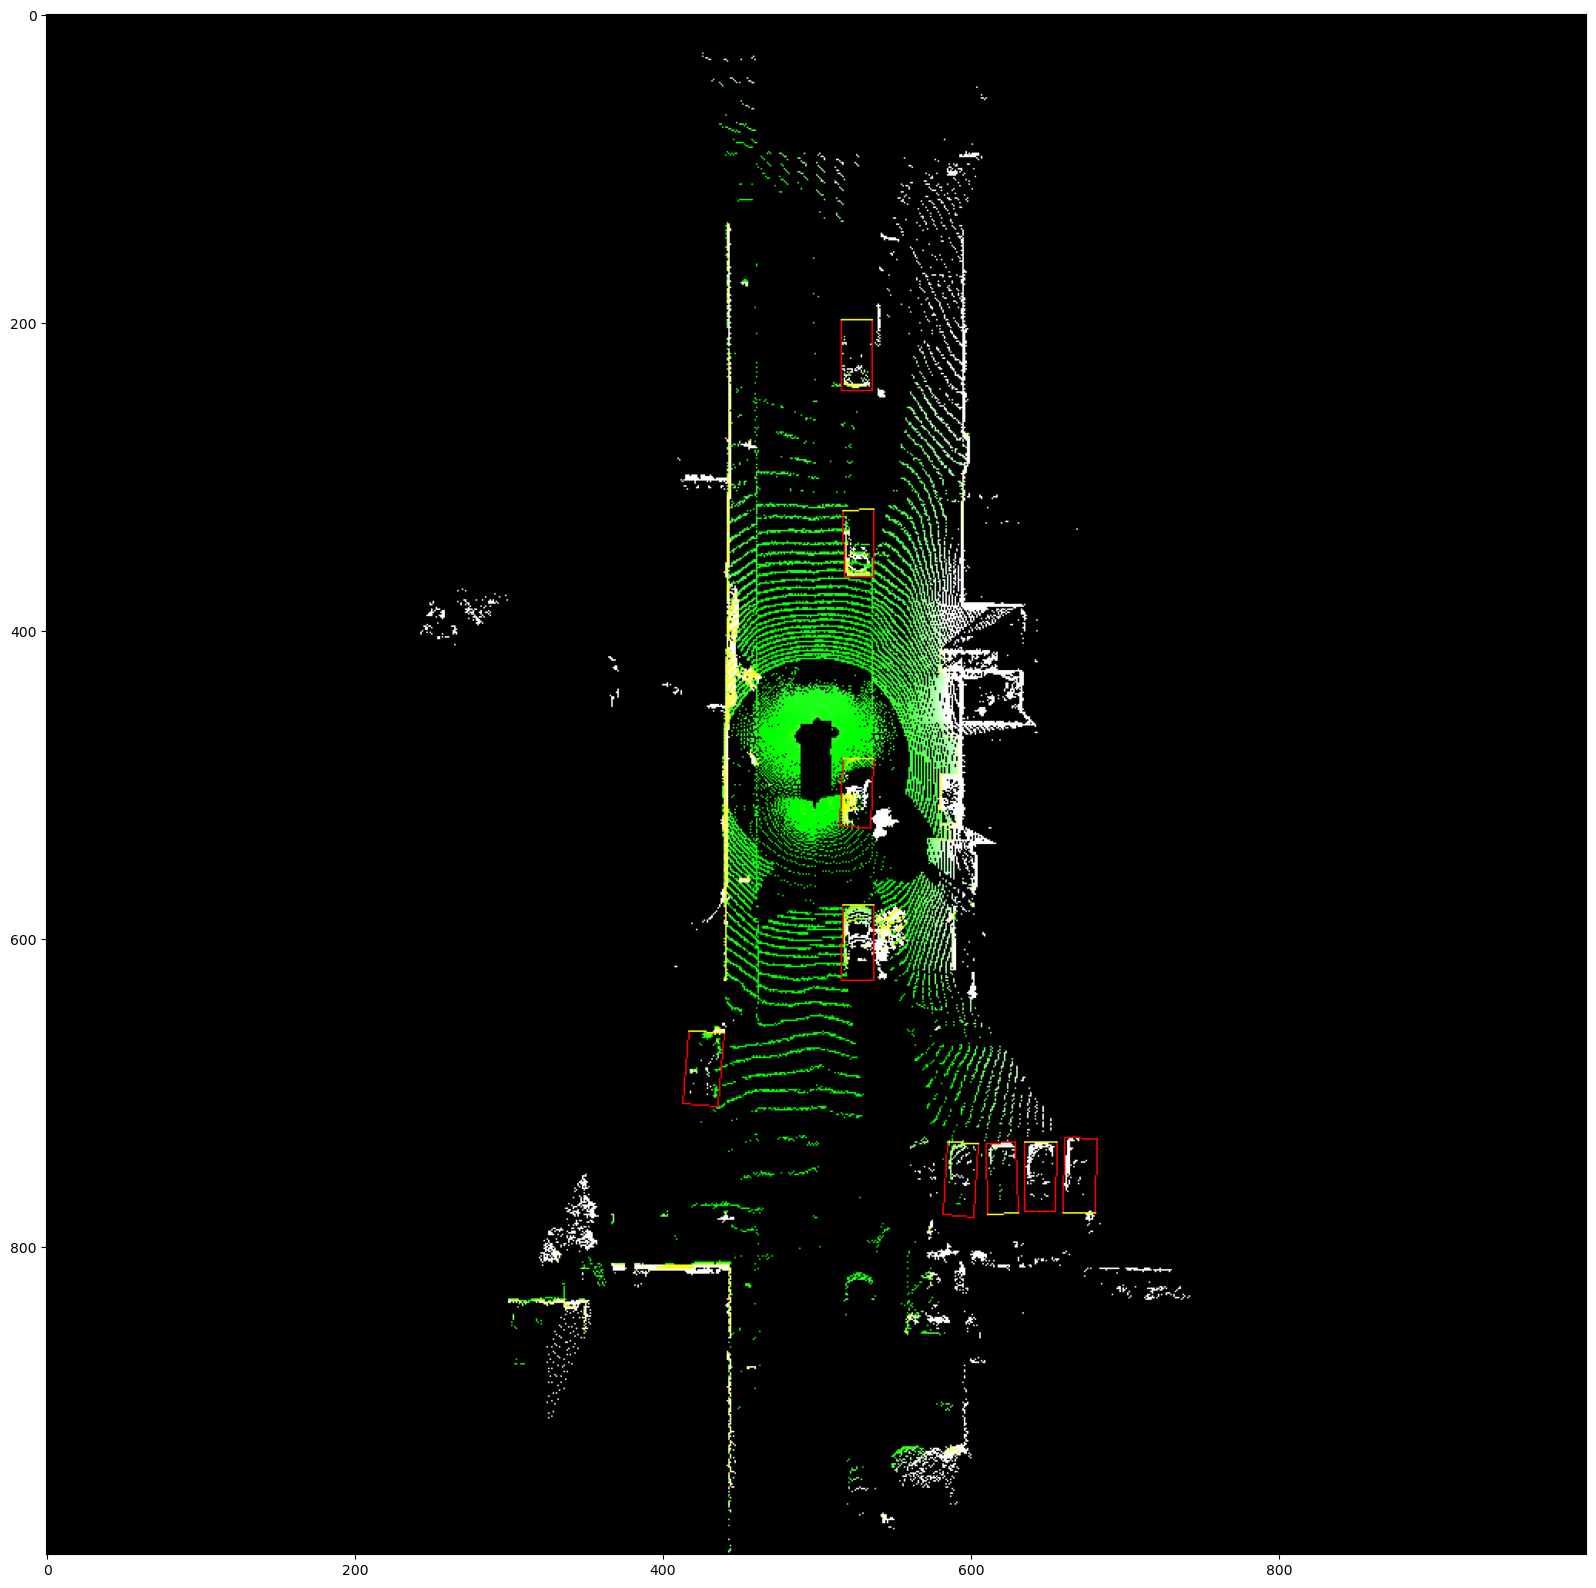

In [13]:
def draw_bboxs(img, path_to_json):

    # Load labels
    with open(path_to_json) as f:
        target = json.load(f)
    
    for obj in target:
    
        if obj["class"] != "TYPE_VEHICLE":
            continue
    
        if obj["num_lidar_points_in_box"] < MIN_LIDAR_POINTS:
            continue

        center = [-obj["center_y"], -obj["center_x"]]
    
        cos_angle = np.cos(obj["heading"])
        sin_angle = np.sin(obj["heading"])
        rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        
        bottom_right = np.dot(rot, np.array([obj["width"]/2, obj["length"]/2]).reshape(2, 1)).reshape(2)
        top_right = np.dot(rot, np.array([obj["width"]/2, -obj["length"]/2]).reshape(2, 1)).reshape(2)
        top_left = np.dot(rot, np.array([-obj["width"]/2, -obj["length"]/2]).reshape(2, 1)).reshape(2)
        bottom_left = np.dot(rot, np.array([-obj["width"]/2, obj["length"]/2]).reshape(2, 1)).reshape(2)
    
        br = (int((center[0]+ bottom_right[0] + WIDTH/2) / VOXEL_SIZE), int((center[1]+ bottom_right[1] + WIDTH/2) / VOXEL_SIZE))
        tr = (int((center[0]+ top_right[0] + WIDTH/2) / VOXEL_SIZE),    int((center[1]+ top_right[1] + WIDTH/2) / VOXEL_SIZE))
        tl = (int((center[0]+ top_left[0] + WIDTH/2) / VOXEL_SIZE),     int((center[1]+ top_left[1] + WIDTH/2) / VOXEL_SIZE))
        bl = (int((center[0]+ bottom_left[0] + WIDTH/2) / VOXEL_SIZE),  int((center[1]+ bottom_left[1] + WIDTH/2) / VOXEL_SIZE))
    
        thickness = 1
        cv2.line(img, br, tr, (220, 0, 0), thickness)
        cv2.line(img, br, bl, (220, 0, 0), thickness)
        cv2.line(img, tl, bl, (220, 0, 0), thickness)
        cv2.line(img, tl, tr, (255, 220, 0), thickness)

    return img

dataset_folder = 'dataset/training/individual_files_training_segment-10017090168044687777_6380_000_6400_000_with_camera_labels/'

# Pick up a random image
ply_file = random.choice(os.listdir(f"{dataset_folder}/pointclouds"))
img = ply_to_map(f"{dataset_folder}/pointclouds/{ply_file}", voxel_size=VOXEL_SIZE)

# Comptute Mean/STD to normalize our network later
MEAN = img.mean(axis=(0, 1))
STD = img.std(axis=(0, 1))
idx = ply_file[-7:-4]
img = draw_bboxs(img, f'{dataset_folder}/labels/labels_{idx}.json')

plt.figure(figsize = (20,20))
plt.imshow(img)

# Utility functions

In [14]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    # print(w, h)
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    # assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [15]:
# Heatmap function
def make_hm_offset_regr_angle(target):
    hm_width = WIDTH_PIXELS//MODEL_SCALE+1
    hm = np.zeros((hm_width, hm_width))
    offset = np.zeros((2,hm_width, hm_width))
    regr = np.zeros((4, hm_width, hm_width))
    cos_sin_hm = np.zeros((2, hm_width, hm_width))
     
    if len(target) == 0:
        return hm, offset, regr, cos_sin_hm

    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    for obj in target:
        if obj["class"] != "TYPE_VEHICLE":
            continue

        if obj["num_lidar_points_in_box"] < MIN_LIDAR_POINTS:
            continue
            
        pos_in_hm = np.array([-obj["center_y"] + WIDTH / 2, -obj["center_x"]+ WIDTH / 2]) / VOXEL_SIZE / MODEL_SCALE
        if (pos_in_hm[0] < 0) or (pos_in_hm[0] >= hm.shape[0]) or (pos_in_hm[1] < 0) or (pos_in_hm[1] >= hm.shape[1]):
            continue
        offset = draw_offset(offset, pos_in_hm[0], pos_in_hm[1])
        pos_in_hm = pos_in_hm.astype(int)
        hm = draw_msra_gaussian(hm, pos_in_hm, sigma=1)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                try:
                    regr[0, pos_in_hm[1]+i, pos_in_hm[0]+j] = obj["width"]
                    regr[1, pos_in_hm[1]+i, pos_in_hm[0]+j] = obj["length"]
                    regr[2, pos_in_hm[1]+i, pos_in_hm[0]+j] = obj["height"]
                    regr[3, pos_in_hm[1]+i, pos_in_hm[0]+j] = obj["center_z"]
                    cos_sin_hm[0, pos_in_hm[1]+i, pos_in_hm[0]+j] = np.cos(obj["heading"])
                    cos_sin_hm[1, pos_in_hm[1]+i, pos_in_hm[0]+j] = np.sin(obj["heading"])
                except:
                    pass
        
    return hm, offset, regr, cos_sin_hm


In [16]:
def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 1:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm

In [17]:
def pred2box(hm, offset, regr, cos_sin_hm, thresh=0.99):
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    pred_angles = cos_sin_hm[:, pred].T
    
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    
    for (center, wlhz, pred_angle) in zip(pred_center, pred_r, pred_angles):
        offset_xy = offset[:, center[0], center[1]]
        angle = np.arctan2(pred_angle[1], pred_angle[0])
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, wlhz[3],
                        wlhz[0], wlhz[1], wlhz[2], angle]) # changed to add height
        boxes.append(arr)
    return np.asarray(boxes)

In [18]:
# functions for plotting results
def showbox(img, hm, offset, regr, cos_sin_hm, thresh=0.9):
    boxes = pred2box(hm, offset, regr, cos_sin_hm, thresh=thresh)
    
    for box in boxes:
        center = [int(box[0]), int(box[1])]
        angle = box[6]
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])

        width = box[3] / VOXEL_SIZE
        length = box[4] / VOXEL_SIZE
        
        bottom_right = np.dot(rot, np.array([width/2, length/2]).reshape(2, 1)).reshape(2)
        top_right = np.dot(rot, np.array([width/2, -length/2]).reshape(2, 1)).reshape(2)
        top_left = np.dot(rot, np.array([-width/2, -length/2]).reshape(2, 1)).reshape(2)
        bottom_left = np.dot(rot, np.array([-width/2, length/2]).reshape(2, 1)).reshape(2)
        
        thickness = 1
        cv2.line(img, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
                      (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
                      (0, 220, 220), thickness)
        cv2.line(img, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
                      (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
                      (0, 220, 220), thickness)
        cv2.line(img, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
                      (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
                      (0, 220, 220), thickness)
        cv2.line(img, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
                      (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
                      (220, 0, 0), thickness)
    return img


# Make Pytorch dataset with dataloader

In [19]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data, train=False):
        self.ply_samples = [str(posix_path) for posix_path in list(Path(path_to_data).glob('**/*.ply'))]
        self.normalize = transforms.Normalize(MEAN, STD)
        self.train = train
        
    def __len__(self):
        return len(self.ply_samples)

    def __getitem__(self, idx):

        angle = np.random.uniform(low=-np.pi, high=np.pi) if self.train else 0
        # angle = 0
        
        img = ply_to_map(self.ply_samples[idx], voxel_size=VOXEL_SIZE, angle = angle)
        img = torch.from_numpy(img).float()
        img = img.permute(2, 0, 1)
        img = self.normalize(img)
        
        idx_in_sample = self.ply_samples[idx][-7:-4]
        path_to_label = Path(self.ply_samples[idx]).parent.parent / "labels" / f"labels_{idx_in_sample}.json"

        with open(path_to_label) as f:
            target = json.load(f)

        if self.train:
            rot = np.array([[np.cos(angle), np.sin(angle)],
                    [-np.sin(angle), np.cos(angle)]])
            for obj in target:
                rotated = rot.dot(np.array([obj["center_x"], obj["center_y"]]).reshape(2, 1)).flatten()
                obj["center_x"] = rotated[0]
                obj["center_y"] = rotated[1]
                obj["heading"] -= angle
            
        hm, offset, regr, cos_sin_hm = make_hm_offset_regr_angle(target)
        return img, hm, offset, regr, cos_sin_hm


In [20]:
traindataset = CarDataset("dataset/training", train=True)
valdataset = CarDataset("dataset/validation")

print(f"Training set : {len(traindataset)} samples")
print(f"Validation set : {len(valdataset)} samples")

Training set : 9919 samples
Validation set : 3944 samples


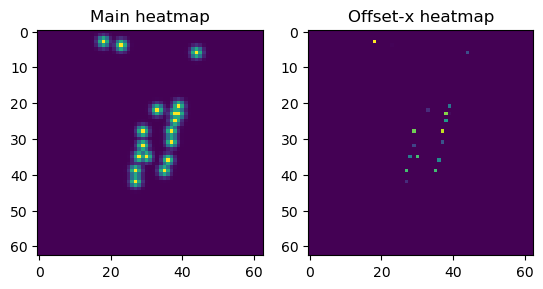

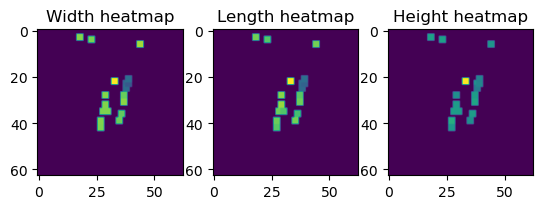

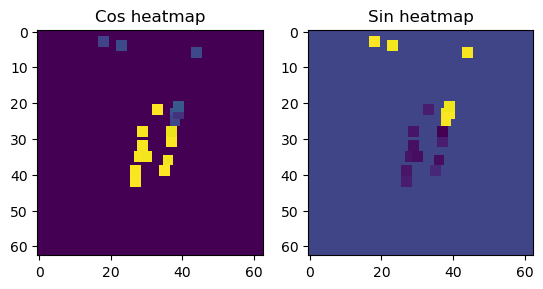

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


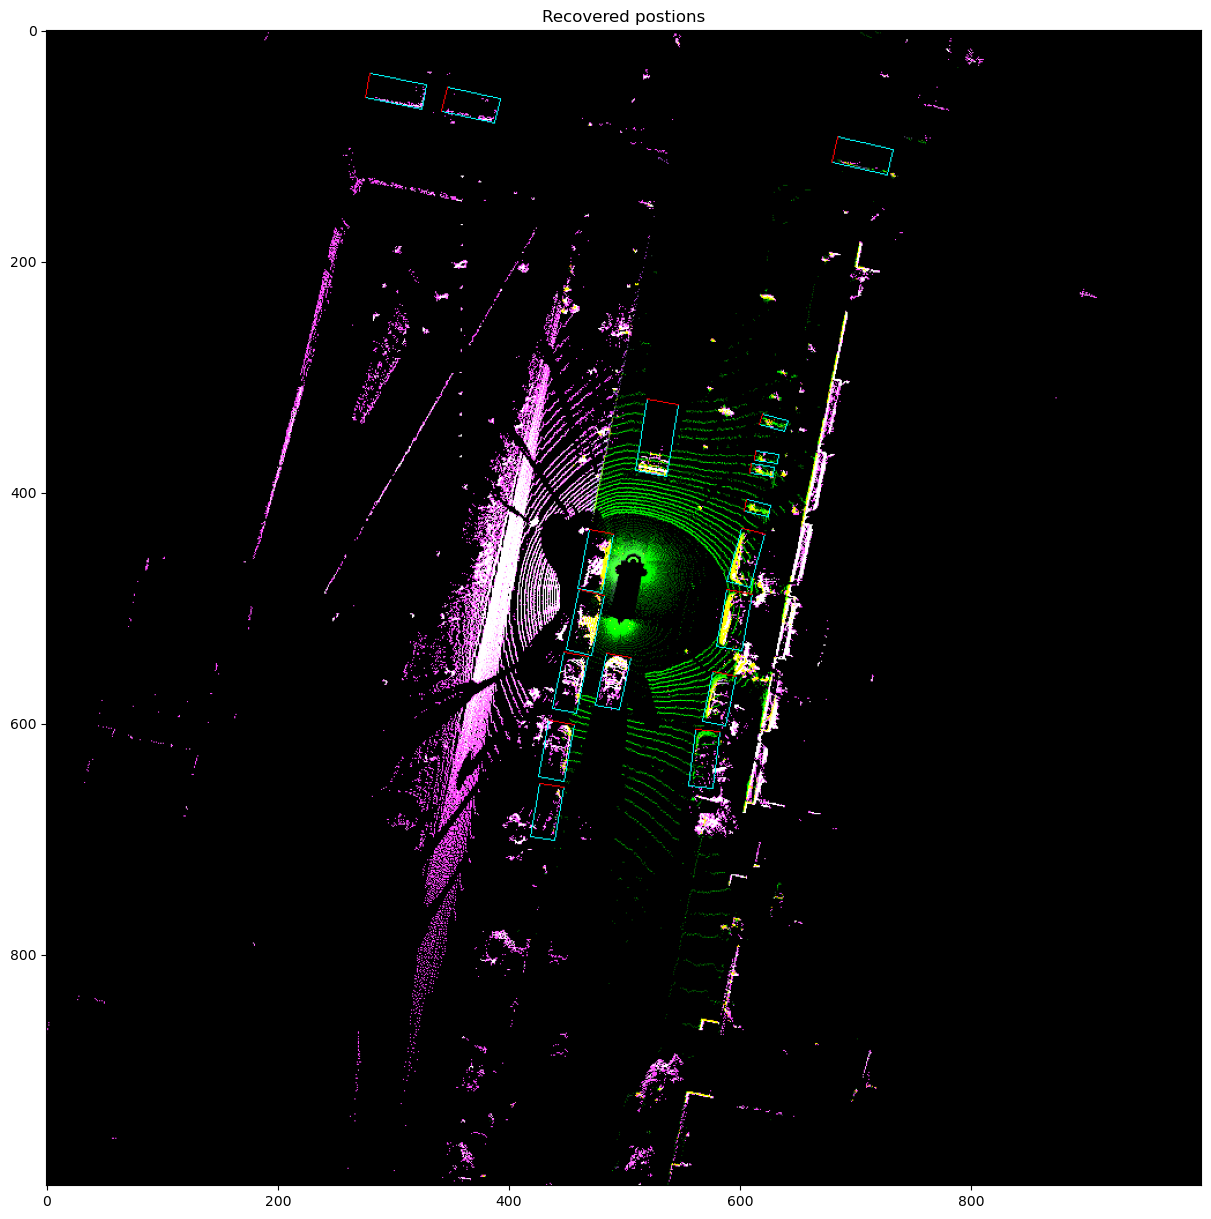

In [21]:
# Check traindataset

k = random.randint(0, len(traindataset))
img, hm, offset, regr, cos_sin_hm = traindataset[k]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(hm)
axs[0].set_title('Main heatmap')
axs[1].imshow(offset[0])
axs[1].set_title('Offset-x heatmap')
plt.show()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(regr[0])
axs[0].set_title('Width heatmap')
axs[1].imshow(regr[1])
axs[1].set_title('Length heatmap')
axs[2].imshow(regr[2])
axs[2].set_title('Height heatmap')
plt.show()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cos_sin_hm[0])
axs[0].set_title('Cos heatmap')
axs[1].imshow(cos_sin_hm[1])
axs[1].set_title('Sin heatmap')
plt.show()

img = img.permute(1, 2, 0).numpy()
img = showbox(img, hm, offset, regr, cos_sin_hm)

plt.figure(figsize = (15,15))
plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [22]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True)

# Define Centernet model

In [23]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        basemodel = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        
        # Select only first layers up when you reach 63x63 dimensions with 256 channels
        self.base_model = nn.Sequential(*list(basemodel.children())[:-3])

        num_ch = 256
        self.bottleneck = nn.Sequential(
                nn.Conv2d(num_ch, num_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(num_ch, num_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_ch),
                nn.ReLU(inplace=True)
        )
        
        head_conv = 128
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 1, kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outr = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 4, kernel_size=1, stride=1))
        
        self.outa = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
    def forward(self, x):
        
        x = self.base_model(x)

        x = self.bottleneck(x)
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        assert not torch.isnan(outo).any()
        
        outr = self.outr(x)
        outa = self.outa(x)
        
        return outc, outo, outr, outa

In [24]:
model = centernet()
# Check if it runs correctly
output = model(torch.rand(1, 3, WIDTH_PIXELS, WIDTH_PIXELS))
print(output[0].size())
print(output[1].size())

torch.Size([1, 1, 63, 63])
torch.Size([1, 2, 63, 63])


In [25]:
summary(model, (1, 3, WIDTH_PIXELS, WIDTH_PIXELS))

Layer (type:depth-idx)                        Output Shape              Param #
centernet                                     [1, 1, 63, 63]            --
├─Sequential: 1-1                             [1, 256, 63, 63]          --
│    └─Conv2d: 2-1                            [1, 64, 500, 500]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 500, 500]         128
│    └─ReLU: 2-3                              [1, 64, 500, 500]         --
│    └─MaxPool2d: 2-4                         [1, 64, 250, 250]         --
│    └─Sequential: 2-5                        [1, 64, 250, 250]         --
│    │    └─BasicBlock: 3-1                   [1, 64, 250, 250]         73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 250, 250]         73,984
│    └─Sequential: 2-6                        [1, 128, 125, 125]        --
│    │    └─BasicBlock: 3-3                   [1, 128, 125, 125]        230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 125, 125]        295,42

# Define Loss (Focal loss + L1-loss)

In [26]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds 
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wlhz_pred, wlhz_gt, angle_pred, angle_gt, hm_gt):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    mask = hm_gt.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    mask2d = mask.expand_as(off_gt).float()
    mask4d = mask.expand_as(wlhz_gt).float()
    
    assert off_pred.size() == mask2d.size()
    off_pred = off_pred * mask2d
    off_gt = off_gt * mask2d
    wlhz_pred = wlhz_pred * mask4d
    wlhz_gt = wlhz_gt * mask4d
    angle_pred = angle_pred * mask2d
    angle_gt = angle_gt * mask2d

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    wlhz_loss = nn.functional.l1_loss(wlhz_pred, wlhz_gt, reduction='sum') / (num + 1e-4)
    
    angle_loss = nn.functional.l1_loss(angle_pred, angle_gt, reduction='sum') / (num + 1e-4)
    
    return off_loss, wlhz_loss, angle_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wlhz_pred, wlhz_gt, angle_pred, angle_gt):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.sigmoid(hm_pred[:, 0])
  
    pred_mask = pred_mask.unsqueeze(1).float()
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wlhz_loss, angle_loss = _regr_loss(off_pred, off_gt, wlhz_pred, wlhz_gt, angle_pred, angle_gt, hm_gt)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss, wlhz_loss, angle_loss

# Training

In [27]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wlhz_loss = 0.0
    train_angle_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    
    for idx, (img, hm, offset, regr, angle) in enumerate(t):
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wlhz_gt = regr.to(device)
        angle_gt = angle.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        preds_hm, preds_offset, preds_wlhz, preds_angle = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])
            
        foc_loss, pos_loss, neg_loss, off_loss, wlhz_loss, angle_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wlhz, wlhz_gt, preds_angle, angle_gt)
        loss = foc_loss + off_loss + wlhz_loss + angle_loss
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wlhz_loss += float(wlhz_loss)
        train_angle_loss += float(angle_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f}) (wlhz={train_wlhz_loss/(idx+1):.3f}) (a={train_angle_loss/(idx+1):.3f})')
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wlhz_loss = 0.0
    val_angle_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr, angle) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wlhz_gt = regr.to(device)
            angle_gt = angle.to(device)

            # run model
            preds_hm, preds_offset, preds_wlhz, preds_angle = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wlhz_loss, angle_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wlhz, wlhz_gt, preds_angle, angle_gt)
            
            loss = foc_loss + off_loss + wlhz_loss + angle_loss
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wlhz_loss += float(wlhz_loss)
            val_angle_loss += float(angle_loss)


    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wlhz loss : {train_wlhz_loss/len(train_loader):.4f}')
    print(f'Angle loss : {train_angle_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wlhz loss : {val_wlhz_loss/len(val_loader):.4f}')
    print(f'Val Angle loss : {val_angle_loss/len(val_loader):.4f}')
    
    return val_loss/len(val_loader)

In [28]:
model = centernet()
# model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))

device = torch.device("cuda")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

logs = []
best_loss = float('inf')

In [ ]:
epochs = 20
for epoch in range(epochs):
    val_loss = train(epoch)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), "centernet-oriented-bbox.pth")   # best was 2.189 for val, 1.01 for train (13 epochs)


epochs 1/20
Learning rate : 0.0001


(l=1.52) (pos=0.313) (neg=0.177) (off=0.166) (wlhz=0.643) (a=0.221): 100%|████████████████████| 2480/2480 [36:22<00:00,  1.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:26<00:00,  1.22it/s]


train loss : 1.5208
Pos loss : 0.3130
Neg loss : 0.1775
Off loss : 0.1657
Wlhz loss : 0.6434
Angle loss : 0.2213

Val loss : 2.2449
Val Pos loss : 0.6653
Val Neg loss : 0.3052
Val Off loss : 0.1832
Val Wlhz loss : 0.7955
Val Angle loss : 0.2958
Improved validation loss to 2.245
epochs 2/20
Learning rate : 0.0001


(l=1.38) (pos=0.269) (neg=0.160) (off=0.155) (wlhz=0.603) (a=0.195): 100%|████████████████████| 2480/2480 [36:24<00:00,  1.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:25<00:00,  1.22it/s]


train loss : 1.3824
Pos loss : 0.2693
Neg loss : 0.1601
Off loss : 0.1549
Wlhz loss : 0.6030
Angle loss : 0.1952

Val loss : 2.2374
Val Pos loss : 0.6242
Val Neg loss : 0.3366
Val Off loss : 0.1767
Val Wlhz loss : 0.7983
Val Angle loss : 0.3017
Improved validation loss to 2.237
epochs 3/20
Learning rate : 0.0001


(l=1.29) (pos=0.245) (neg=0.149) (off=0.147) (wlhz=0.576) (a=0.176): 100%|████████████████████| 2480/2480 [36:25<00:00,  1.13it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:25<00:00,  1.22it/s]


train loss : 1.2922
Pos loss : 0.2450
Neg loss : 0.1487
Off loss : 0.1469
Wlhz loss : 0.5755
Angle loss : 0.1760

Val loss : 2.1252
Val Pos loss : 0.6727
Val Neg loss : 0.2249
Val Off loss : 0.1727
Val Wlhz loss : 0.7781
Val Angle loss : 0.2769
Improved validation loss to 2.125
epochs 4/20
Learning rate : 0.0001


(l=1.21) (pos=0.220) (neg=0.138) (off=0.141) (wlhz=0.552) (a=0.163): 100%|████████████████████| 2480/2480 [36:22<00:00,  1.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:24<00:00,  1.23it/s]


train loss : 1.2140
Pos loss : 0.2204
Neg loss : 0.1379
Off loss : 0.1412
Wlhz loss : 0.5519
Angle loss : 0.1627

Val loss : 2.2016
Val Pos loss : 0.7257
Val Neg loss : 0.2345
Val Off loss : 0.1683
Val Wlhz loss : 0.7581
Val Angle loss : 0.3150
epochs 5/20
Learning rate : 0.0001


(l=1.16) (pos=0.204) (neg=0.132) (off=0.136) (wlhz=0.531) (a=0.152): 100%|████████████████████| 2480/2480 [36:23<00:00,  1.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:23<00:00,  1.23it/s]


train loss : 1.1559
Pos loss : 0.2045
Neg loss : 0.1321
Off loss : 0.1360
Wlhz loss : 0.5314
Angle loss : 0.1519

Val loss : 2.1073
Val Pos loss : 0.6543
Val Neg loss : 0.2602
Val Off loss : 0.1677
Val Wlhz loss : 0.7551
Val Angle loss : 0.2699
Improved validation loss to 2.107
epochs 6/20
Learning rate : 0.0001


(l=1.11) (pos=0.194) (neg=0.127) (off=0.132) (wlhz=0.517) (a=0.144): 100%|████████████████████| 2480/2480 [36:12<00:00,  1.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:26<00:00,  1.22it/s]


train loss : 1.1139
Pos loss : 0.1942
Neg loss : 0.1267
Off loss : 0.1318
Wlhz loss : 0.5175
Angle loss : 0.1438

Val loss : 2.1586
Val Pos loss : 0.8122
Val Neg loss : 0.1594
Val Off loss : 0.1653
Val Wlhz loss : 0.7589
Val Angle loss : 0.2628
epochs 7/20
Learning rate : 0.0001


(l=1.07) (pos=0.182) (neg=0.121) (off=0.128) (wlhz=0.503) (a=0.136): 100%|████████████████████| 2480/2480 [36:14<00:00,  1.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:25<00:00,  1.22it/s]


train loss : 1.0702
Pos loss : 0.1818
Neg loss : 0.1209
Off loss : 0.1283
Wlhz loss : 0.5028
Angle loss : 0.1364

Val loss : 2.0828
Val Pos loss : 0.6909
Val Neg loss : 0.2406
Val Off loss : 0.1587
Val Wlhz loss : 0.7438
Val Angle loss : 0.2487
Improved validation loss to 2.083
epochs 8/20
Learning rate : 0.0001


(l=1.03) (pos=0.170) (neg=0.116) (off=0.125) (wlhz=0.490) (a=0.129): 100%|████████████████████| 2480/2480 [36:17<00:00,  1.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:25<00:00,  1.22it/s]


train loss : 1.0296
Pos loss : 0.1697
Neg loss : 0.1159
Off loss : 0.1253
Wlhz loss : 0.4898
Angle loss : 0.1290

Val loss : 2.1700
Val Pos loss : 0.7761
Val Neg loss : 0.2447
Val Off loss : 0.1615
Val Wlhz loss : 0.7417
Val Angle loss : 0.2461
epochs 9/20
Learning rate : 0.0001


(l=1.00) (pos=0.161) (neg=0.112) (off=0.123) (wlhz=0.477) (a=0.125): 100%|████████████████████| 2480/2480 [36:19<00:00,  1.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████| 986/986 [13:24<00:00,  1.23it/s]


train loss : 0.9980
Pos loss : 0.1610
Neg loss : 0.1120
Off loss : 0.1230
Wlhz loss : 0.4769
Angle loss : 0.1251

Val loss : 2.1964
Val Pos loss : 0.8712
Val Neg loss : 0.1783
Val Off loss : 0.1588
Val Wlhz loss : 0.7503
Val Angle loss : 0.2378
epochs 10/20
Learning rate : 0.0001


(l=0.97) (pos=0.155) (neg=0.108) (off=0.120) (wlhz=0.466) (a=0.119):  82%|████████████████▍   | 2040/2480 [29:58<06:26,  1.14it/s]

# Show predictions

## On validation set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


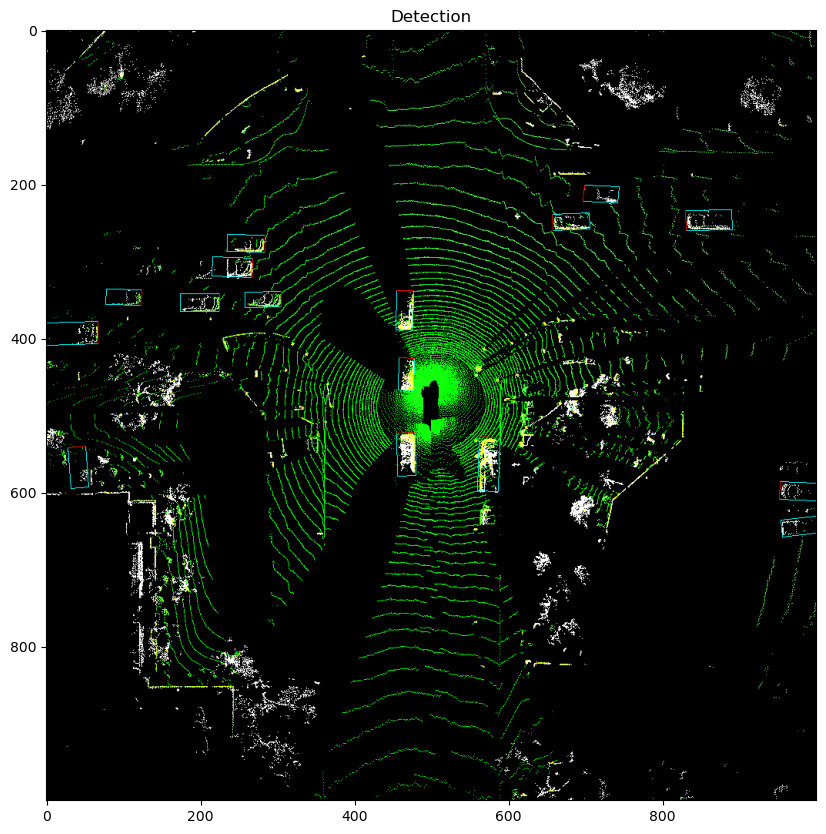

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


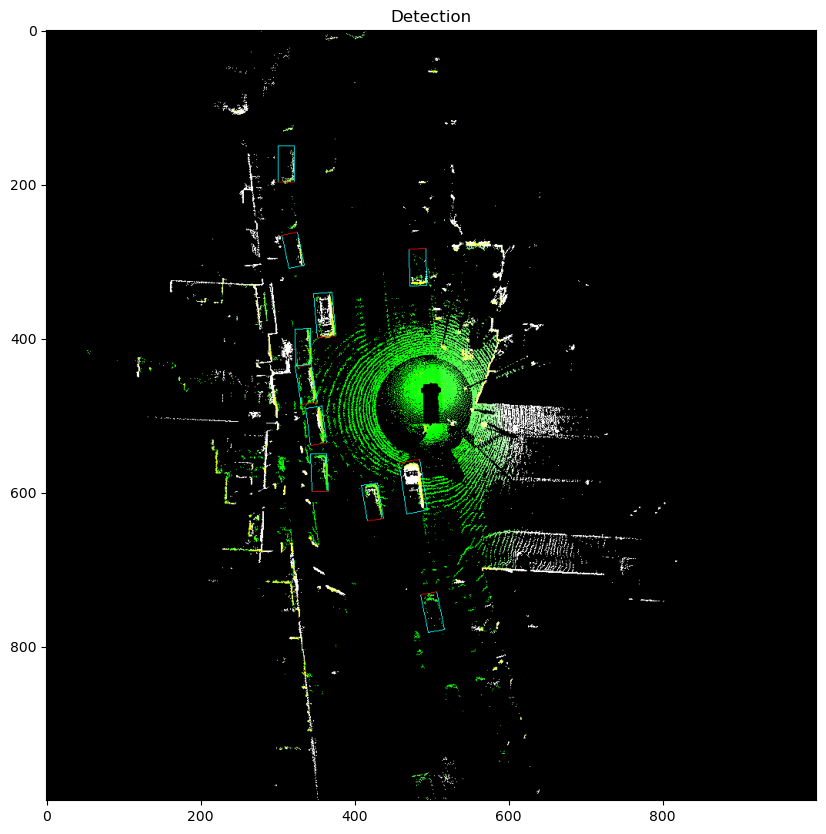

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


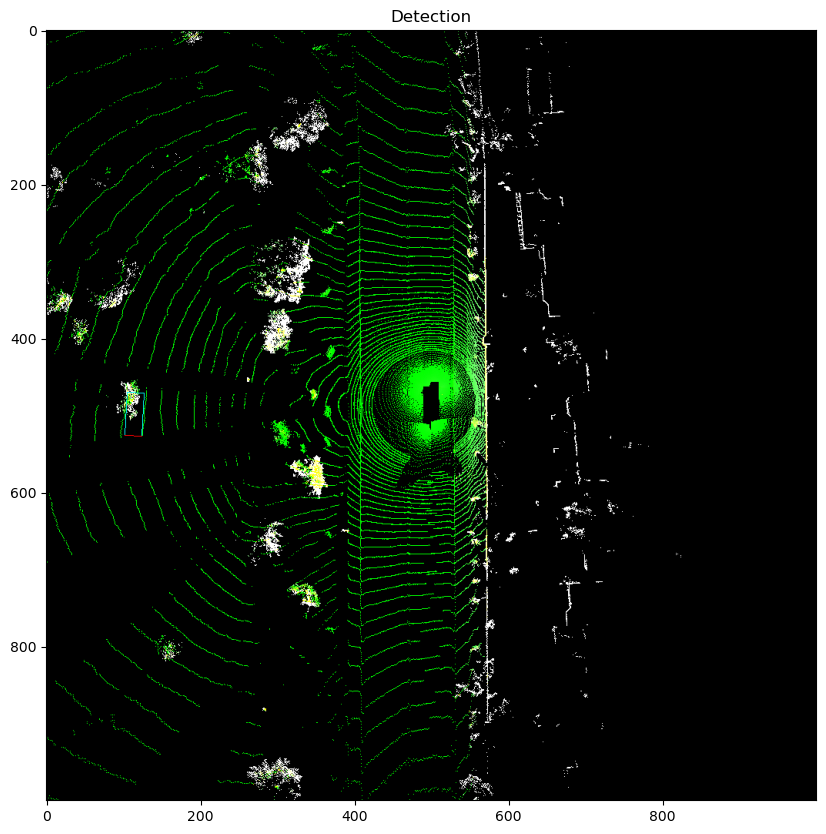

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


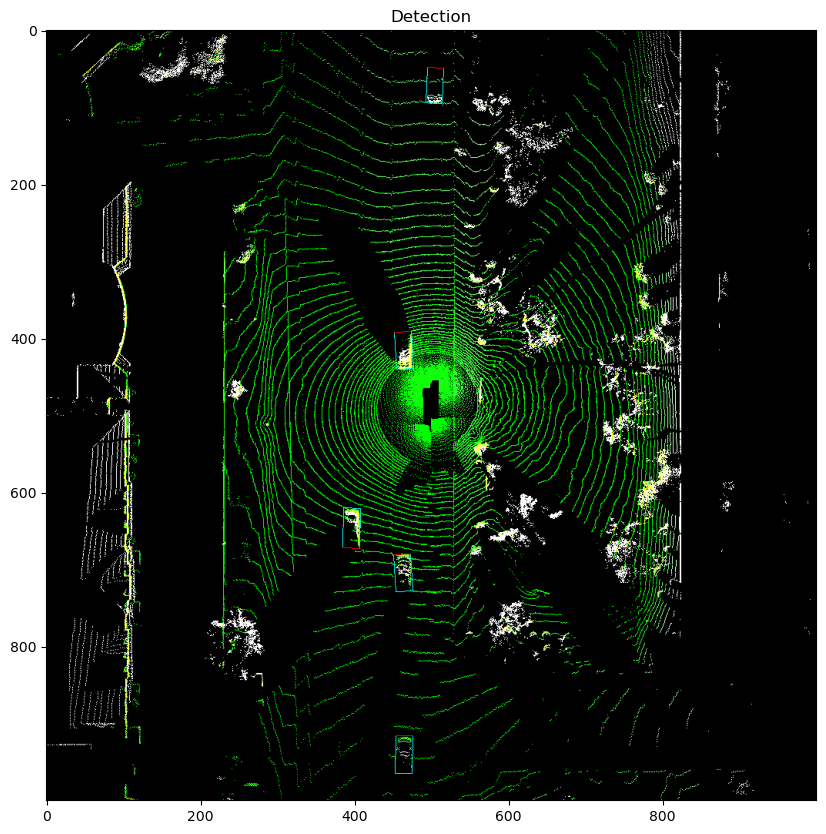

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


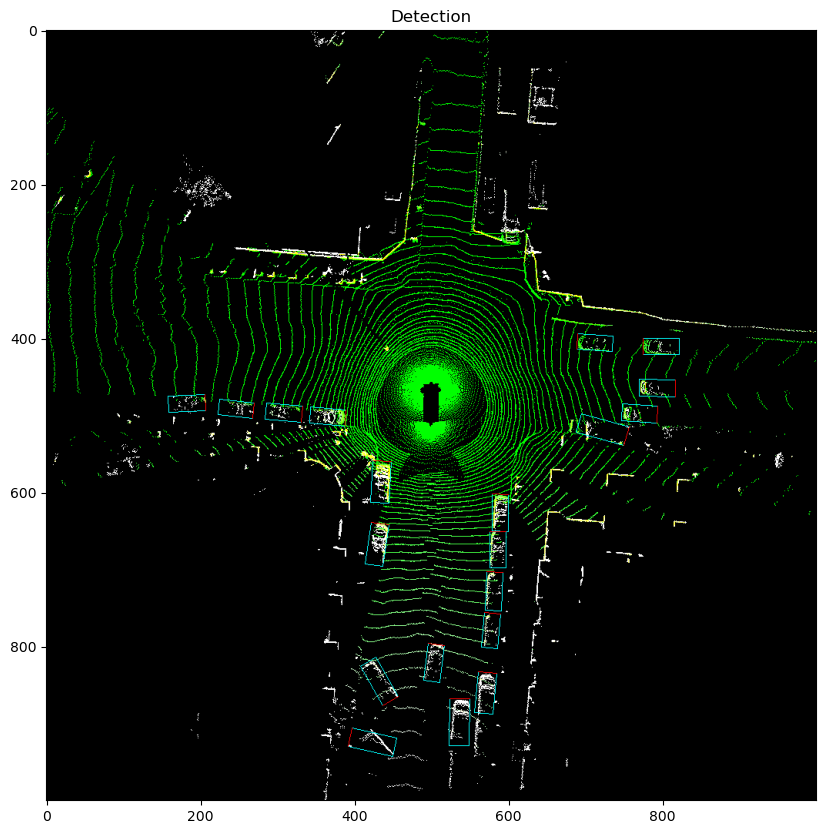

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


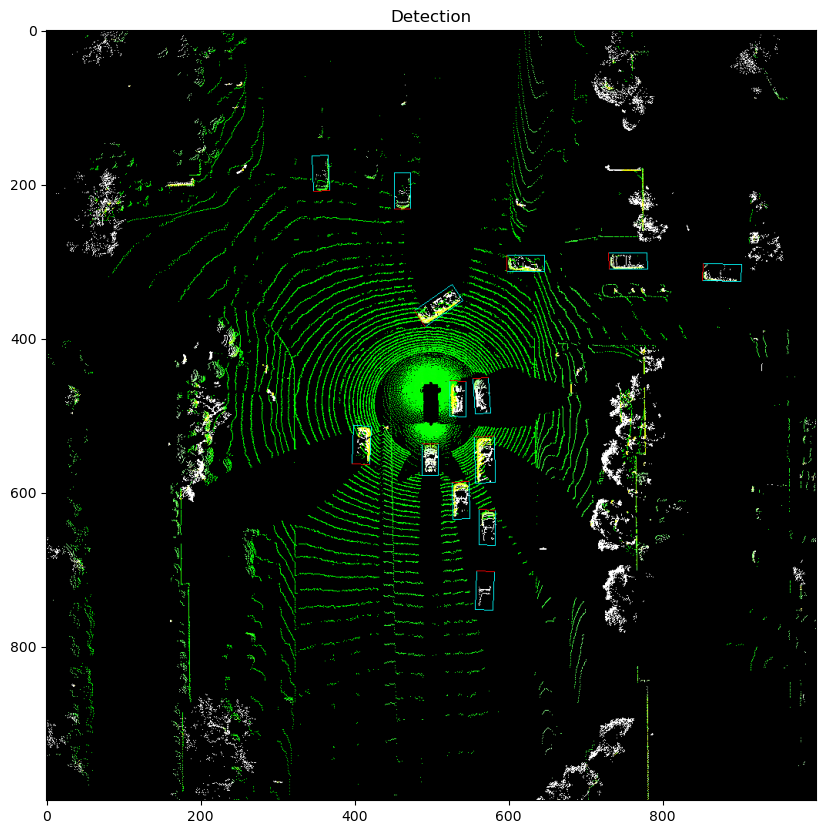

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


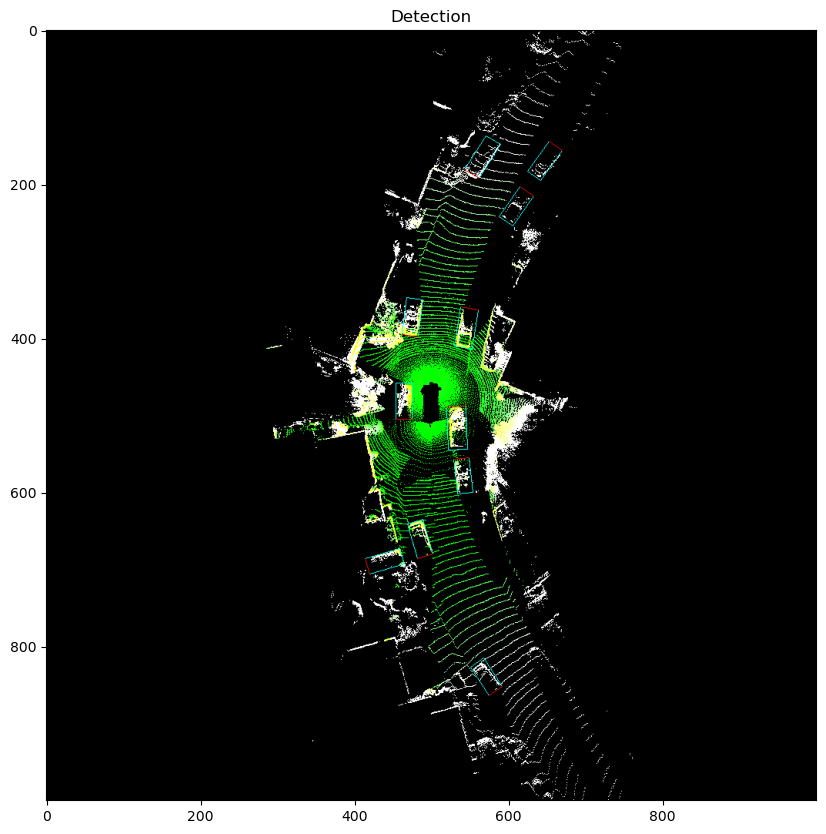

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


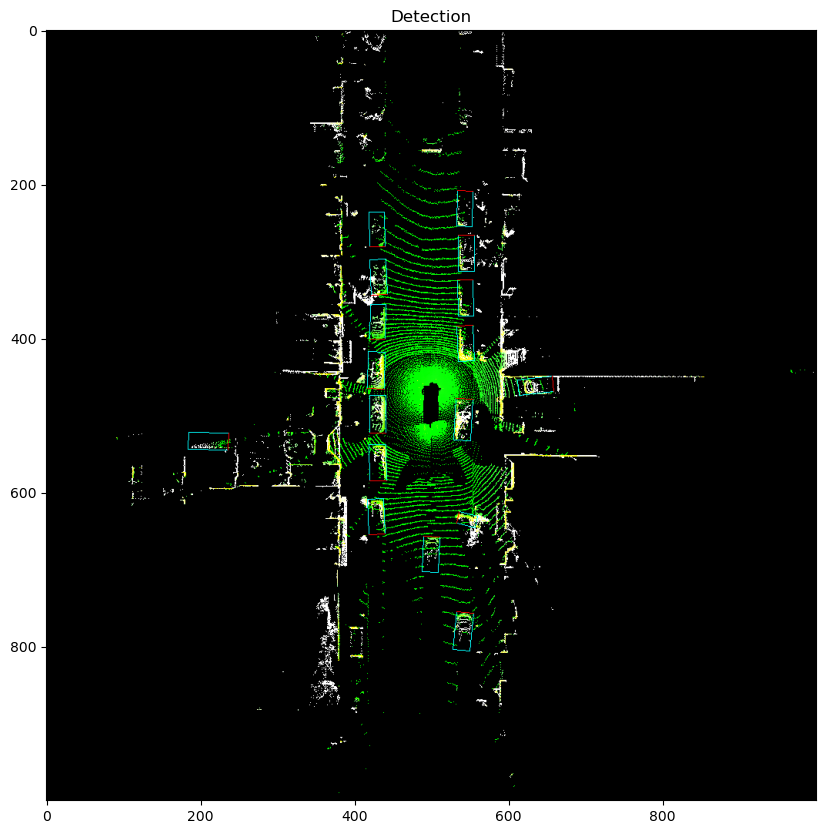

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


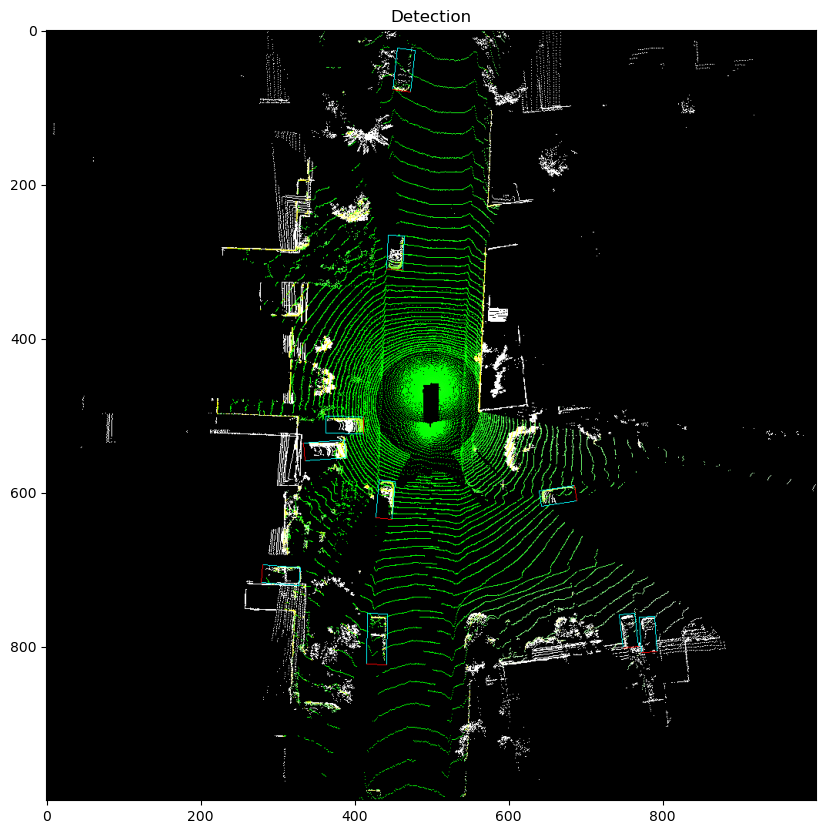

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


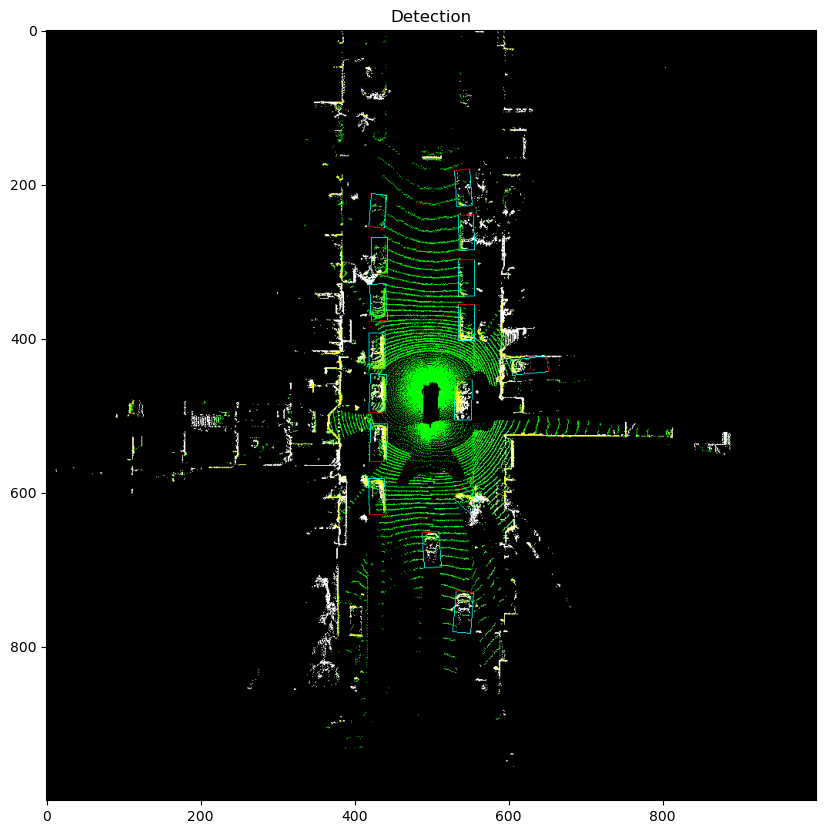

In [29]:
model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))
model.eval()

threshold = 0.5

for id in random.sample(range(0, len(valdataset)), 10):
    img, hm_gt, offset_gt, regr_gt, angle_gt = valdataset[id]
    with torch.no_grad():
        hm, offset, wlh, angle = model(img.to(device).float().unsqueeze(0))

    
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wlh = wlh.cpu().numpy().squeeze(0)
    angle = angle.cpu().numpy().squeeze(0)

    # show image
    img = ply_to_map(valdataset.ply_samples[id], voxel_size=VOXEL_SIZE)

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = select(hm, threshold)
    
    sample = showbox(img, hm, offset, wlh, angle, threshold)
    
    # show gt
    plt.figure(figsize = (10,10))
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()

# Perform inference

In [49]:
def ply_to_image(ply, voxel_size=0.2):
    pcd = o3d.io.read_point_cloud(ply)
    point_cloud_in_numpy = np.asarray(pcd.points)
    point_cloud_in_numpy[:, 0:2] = -point_cloud_in_numpy[:, 0:2]

    img = np.zeros((WIDTH_PIXELS, WIDTH_PIXELS, 3), dtype=np.uint8)

    indices = (point_cloud_in_numpy[:, :2] + WIDTH/2) / voxel_size
    indices = indices.astype(int)
    # remove oob
    args = (0 <= indices[:, 0]) & (indices[:, 0] < WIDTH_PIXELS) & (0 <= indices[:, 1]) & (indices[:, 1] < WIDTH_PIXELS)
    indices = indices[args]

    img[indices[:, 0], indices[:, 1], :] = 255
    return img

# Write inference

In [30]:
def infer_sample(sample):
    nb_frames = len(os.listdir(f"{sample}/pointclouds/"))
    
    os.makedirs(f"{sample}/inference", exist_ok = True)
    threshold = 0.5
    
    for idx in tqdm(range(1, nb_frames + 1)):
        path_to_ply = f"{sample}/pointclouds/pointcloud_{idx:03d}.ply"
        img = ply_to_map(path_to_ply, voxel_size=VOXEL_SIZE)
        img = torch.from_numpy(img).float()
        img = img.permute(2, 0, 1)
        img = valdataset.normalize(img)
    
        with torch.no_grad():
            hm, offset, wlhz, angle = model(img.to(device).float().unsqueeze(0))
    
        hm = hm.cpu().numpy().squeeze(0).squeeze(0)
        offset = offset.cpu().numpy().squeeze(0)
        wlhz = wlhz.cpu().numpy().squeeze(0)
        angle = angle.cpu().numpy().squeeze(0)
    
        # get boxes
        
        hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
        hm = select(hm, threshold)
        
        boxes = pred2box(hm, offset, wlhz, angle, threshold)
        res = []
        for box in boxes:
            # Convert back to original coordinates
    
            y = -(box[0] * VOXEL_SIZE - WIDTH / 2.0)
            x = -(box[1] * VOXEL_SIZE - WIDTH / 2.0)
            # z is height/2 because the objects are on z = 0
            res.append({"class": "TYPE_VEHICLE", "center_x": x, "center_y": y, "center_z": box[2], "width": box[3], "length": box[4], "height": box[5], "heading": box[6], "num_lidar_points_in_box": 1000})
            
        with open(f"{sample}/inference/inference_{idx:03d}.json", 'w') as f:
            json.dump(res, f)

In [31]:
# sample = "dataset/validation/individual_files_validation_segment-10203656353524179475_7625_000_7645_000_with_camera_labels/"
# sample = "dataset/validation/individual_files_validation_segment-1024360143612057520_3580_000_3600_000_with_camera_labels/"
# sample = "dataset/validation/individual_files_validation_segment-10247954040621004675_2180_000_2200_000_with_camera_labels/" # good one
# sample = "dataset/validation/individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels/" # good at the end
# sample = "dataset/validation/individual_files_validation_segment-10335539493577748957_1372_870_1392_870_with_camera_labels/" # by night, not too bad
# sample = "dataset/validation/individual_files_validation_segment-10359308928573410754_720_000_740_000_with_camera_labels/" # too steap, big miss
# sample = "dataset/validation/individual_files_validation_segment-10448102132863604198_472_000_492_000_with_camera_labels/" # static
# sample = "dataset/validation/individual_files_validation_segment-10689101165701914459_2072_300_2092_300_with_camera_labels/" # too short
# sample = "dataset/validation/individual_files_validation_segment-1071392229495085036_1844_790_1864_790_with_camera_labels/" # empty
# sample = "dataset/validation/individual_files_validation_segment-10837554759555844344_6525_000_6545_000_with_camera_labels/" # urban good
# sample = "dataset/validation/individual_files_validation_segment-10868756386479184868_3000_000_3020_000_with_camera_labels" # stuck in traffic jam
# sample = "dataset/validation/individual_files_validation_segment-11037651371539287009_77_670_97_670_with_camera_labels" # good, night
# sample = "dataset/validation/individual_files_validation_segment-11048712972908676520_545_000_565_000_with_camera_labels" # ok
# sample = "dataset/validation/individual_files_validation_segment-1105338229944737854_1280_000_1300_000_with_camera_labels" # parking lot
# sample = "dataset/validation/individual_files_validation_segment-11356601648124485814_409_000_429_000_with_camera_labels" # good, rain
# sample = "dataset/validation/individual_files_validation_segment-11387395026864348975_3820_000_3840_000_with_camera_labels" # bof
# sample = "dataset/validation/individual_files_validation_segment-11406166561185637285_1753_750_1773_750_with_camera_labels" # bad
# sample = "dataset/validation/individual_files_validation_segment-11434627589960744626_4829_660_4849_660_with_camera_labels" # ok, fast
# sample = "dataset/validation/individual_files_validation_segment-11450298750351730790_1431_750_1451_750_with_camera_labels" # very good
# sample = "dataset/validation/individual_files_validation_segment-11616035176233595745_3548_820_3568_820_with_camera_labels" # empty

for sample in sorted(os.listdir("dataset/validation/")):
    print(f"Infer {sample}...")
    infer_sample(f"dataset/validation/{sample}")


Infer individual_files_validation_segment-10203656353524179475_7625_000_7645_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:43<00:00,  4.59it/s]


Infer individual_files_validation_segment-1024360143612057520_3580_000_3600_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:47<00:00,  4.20it/s]


Infer individual_files_validation_segment-10247954040621004675_2180_000_2200_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:50<00:00,  3.96it/s]


Infer individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:48<00:00,  4.09it/s]


Infer individual_files_validation_segment-10335539493577748957_1372_870_1392_870_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:48<00:00,  4.11it/s]


Infer individual_files_validation_segment-10359308928573410754_720_000_740_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:49<00:00,  4.05it/s]


Infer individual_files_validation_segment-10448102132863604198_472_000_492_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:40<00:00,  4.57it/s]


Infer individual_files_validation_segment-10689101165701914459_2072_300_2092_300_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:50<00:00,  3.91it/s]


Infer individual_files_validation_segment-1071392229495085036_1844_790_1864_790_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:48<00:00,  4.08it/s]


Infer individual_files_validation_segment-10837554759555844344_6525_000_6545_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:46<00:00,  4.27it/s]


Infer individual_files_validation_segment-10868756386479184868_3000_000_3020_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:48<00:00,  4.08it/s]


Infer individual_files_validation_segment-11037651371539287009_77_670_97_670_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:49<00:00,  3.85it/s]


Infer individual_files_validation_segment-11048712972908676520_545_000_565_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:46<00:00,  4.31it/s]


Infer individual_files_validation_segment-1105338229944737854_1280_000_1300_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:47<00:00,  4.16it/s]


Infer individual_files_validation_segment-11356601648124485814_409_000_429_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:42<00:00,  4.66it/s]


Infer individual_files_validation_segment-11387395026864348975_3820_000_3840_000_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:50<00:00,  3.87it/s]


Infer individual_files_validation_segment-11406166561185637285_1753_750_1773_750_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:51<00:00,  3.88it/s]


Infer individual_files_validation_segment-11434627589960744626_4829_660_4849_660_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:43<00:00,  4.53it/s]


Infer individual_files_validation_segment-11450298750351730790_1431_750_1451_750_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:46<00:00,  4.27it/s]


Infer individual_files_validation_segment-11616035176233595745_3548_820_3568_820_with_camera_labels...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:48<00:00,  4.13it/s]
